This notebook expects you've already run `lvl2_downloads.ipynb` to get the data and `phat_gaia_match.ipynb` to get the PHAT->Gaia WCS solution

In [1]:
import json
from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord
from astropy import visualization as aviz

import jwst.datamodels

import photutils

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# Find all the images and create the associated wcses

In [3]:
jwdl = Path('mastDownload/JWST/')
list(list(jwdl.iterdir())[0].iterdir())

[PosixPath('mastDownload/JWST/jw02609001001_02101_00001_nrca1/jw02609001001_02101_00001_nrca1_i2d.fits'),
 PosixPath('mastDownload/JWST/jw02609001001_02101_00001_nrca1/jw02609001001_02101_00001_nrca1_i2d_phatgaiadr3wcs.fits')]

In [4]:
wcspaths = list(jwdl.glob('**/*phatgaiadr3wcs.fits'))
im2dpaths = [Path(str(path).replace('_phatgaiadr3wcs.fits', '.fits')) for path in wcspaths]

In [5]:
wcses = [WCS(fits.getheader(path)) for path in wcspaths]

Set OBSGEO-B to   -26.223612 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598977707.152 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -26.215042 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598854930.920 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -26.213001 from OBSGEO-[XYZ].
Set OBSGEO-H to 1598825695.212 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


# Load the PHAT data

In [6]:
phat_tab = QTable.read('hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits')
phat_tab['coord'] = SkyCoord.guess_from_table(phat_tab, unit='deg')

In [31]:
with open('phat_astrom_correction.json') as f:
    phat_astrom_correction = json.load(f)

phat_tab['coord_corr'] = SkyCoord(
    ra=phat_tab['coord'].ra + phat_astrom_correction['ra_to_add_to_phat_deg']*u.deg, 
    dec=phat_tab['coord'].dec + phat_astrom_correction['dec_to_add_to_phat_deg']*u.deg
)

### MSATA stars

Now select some candidate MSATA stars.  Limits (next cell) are taken from PHAT_msata_tests.ipynb

In [32]:
## E's values from running ETC for M32 catalog (optical filters)
#saturation_limit = 19.2 # according to ETC in F110W with NSRAPID  #vegamag is 19.2 abmag is 19.5
#faint_limit = 23.2 # S/N > 20 in F110W with NSRAPID # vegamag is 23.2 abmag is 23.5
#companion_mag_cutoff = 26

# K's values from running ETC for PHAT catalog
saturation_limit = 19.0 # according to ETC - source mag in vegamag F110W WFC3/IR, strategy: with NSRAPID in F110W
# using JDOX table - this is a more conservative choice
saturation_limit = 19.5 

faint_limit = 22.1 # S/N > 20 according to ETC; vegamag F110W WFC3/IR, with NSRAPID in F110W
# unlike saturation limit, above is approx. the same as the JDOX table, which is 22.0 in F110W NIRSpec
faint_limit_for_mag_contrast = faint_limit + 2  # this *must* be fainter than faint_limit for the code below to work right
companion_mag_cutoff = faint_limit + 10.  # this is for determining what counts when looking for companions within 0.3 arcsec

flux_factor_for_contrast = 10**((faint_limit_for_mag_contrast - faint_limit)/-2.5)



# "gst" field is true for good stars
msata_candidates = phat_tab[(saturation_limit < phat_tab['f110w_vega'])&(phat_tab['f110w_vega'] < faint_limit)&phat_tab['f110w_gst']]
len(msata_candidates)

71896

# Test comparison with one of the i2ds

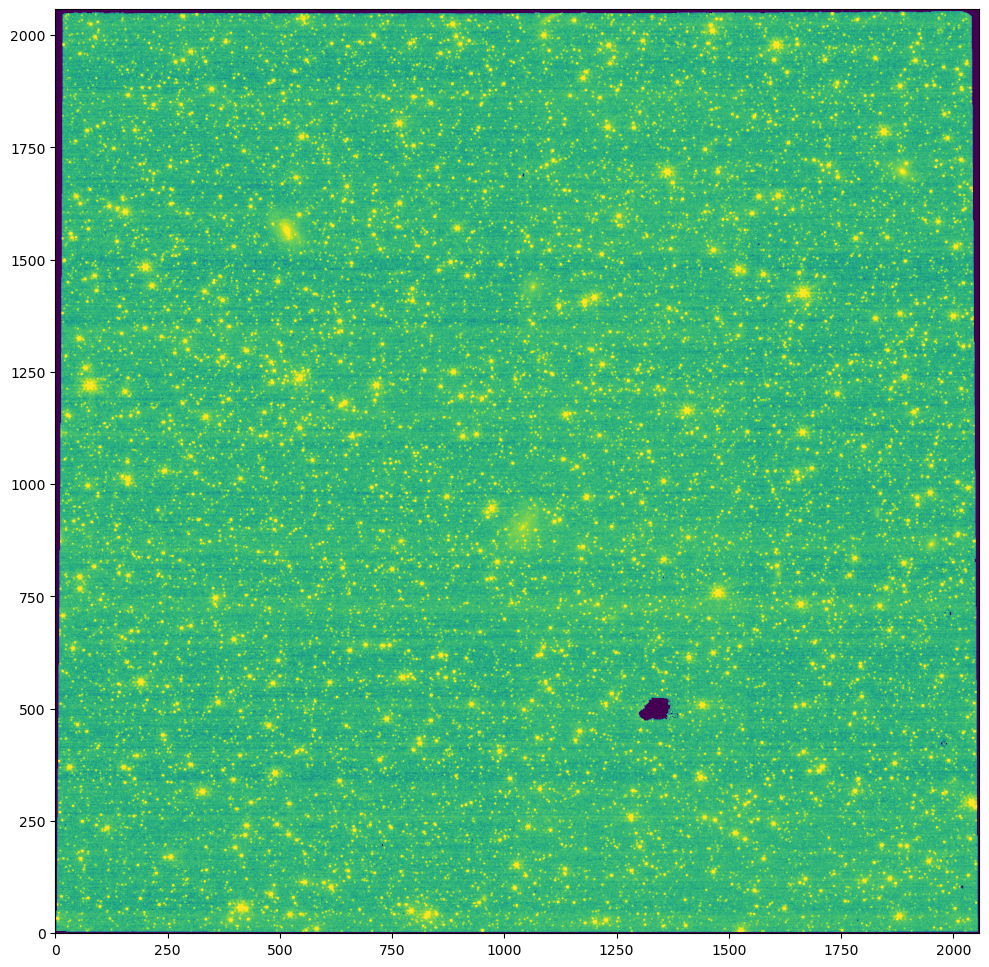

In [33]:
i2d_img = jwst.datamodels.open(im2dpaths[0])
w = wcses[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch());

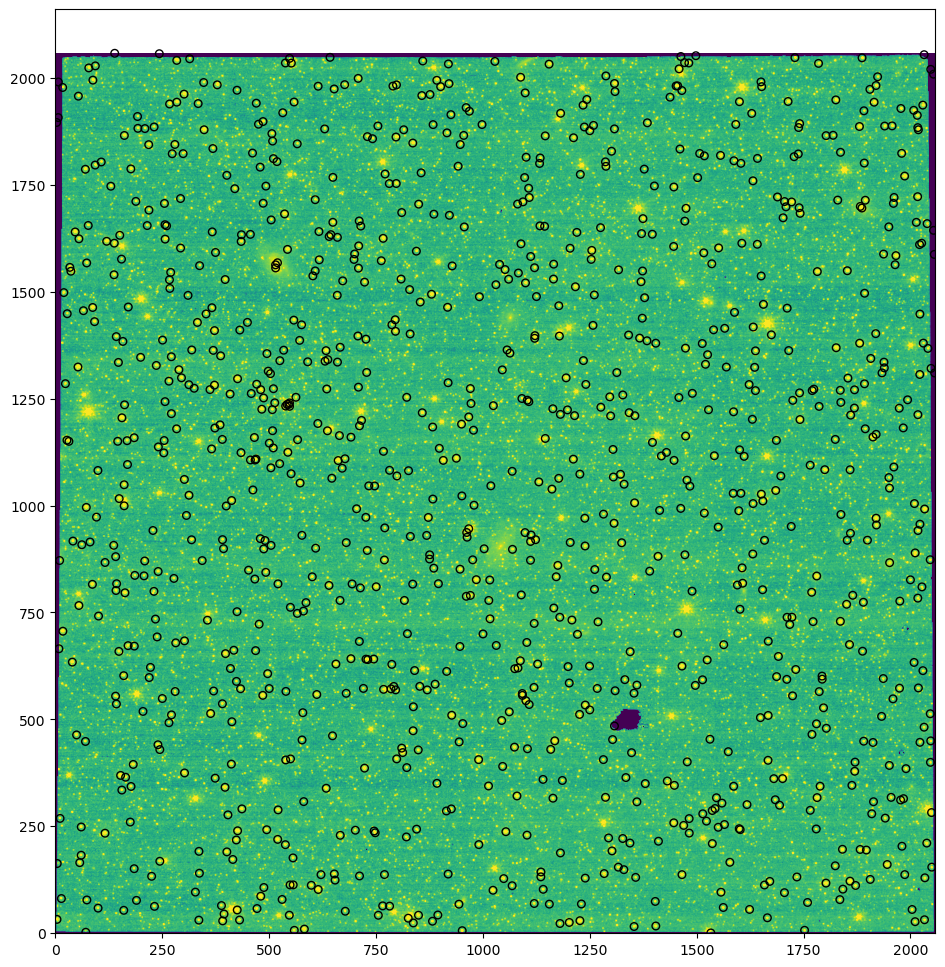

In [34]:
px, py = w.world_to_pixel(msata_candidates['coord_corr'])
inimg = ((0 < px) & (px < i2d_img.shape[1]) & 
         (0 < py) & (py < i2d_img.shape[0]))

msata_inimg_candidates = msata_candidates[inimg]

ax.scatter(px[inimg], py[inimg], s=30, linewidths=1, c='none', edgecolors='black')
fig

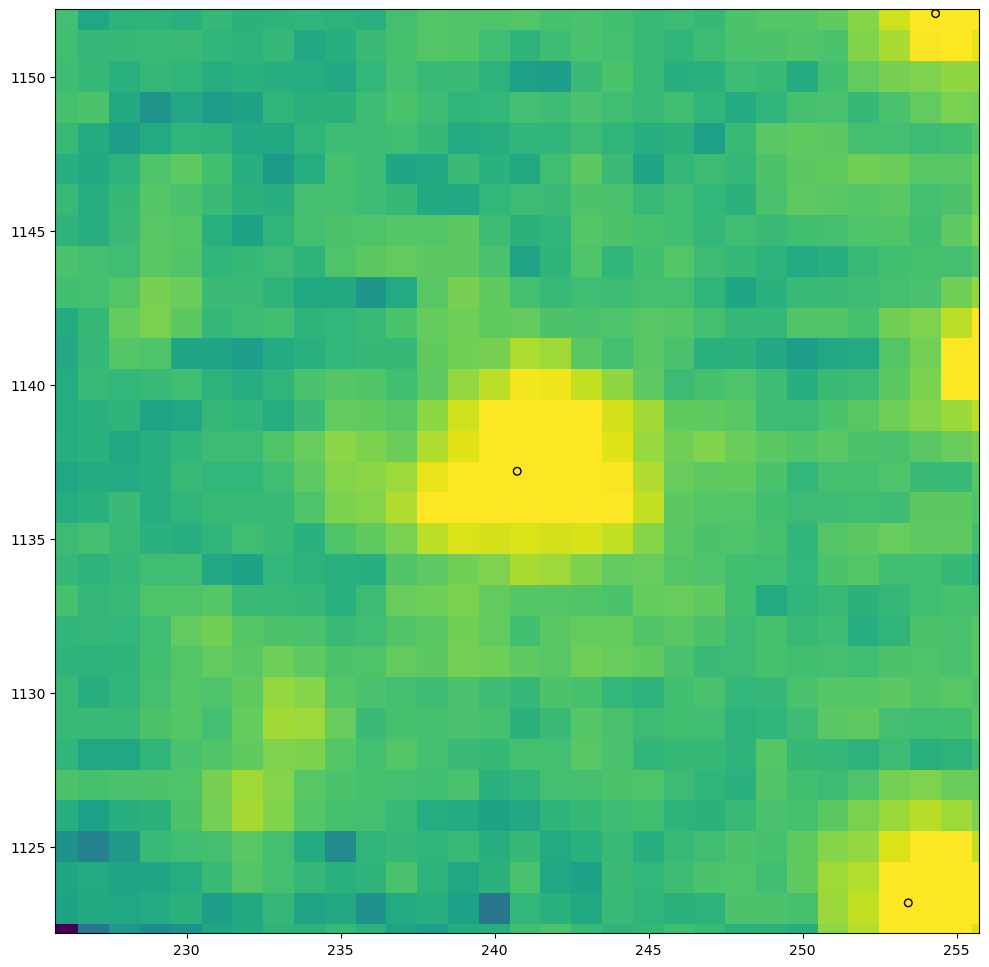

In [35]:
i = np.random.randint(np.sum(inimg))

x0 = px[inimg][i]
y0 = py[inimg][i]
wi = 30

ax.set_xlim(x0 - wi/2, x0 + wi/2)
ax.set_ylim(y0 - wi/2, y0 + wi/2)

fig.savefig('cutout_example.png')

fig

2022-10-28 17:50:28,394 - stpipe - WARNING - /tmp/ipykernel_13979/2299634181.py:4: RuntimeWarning: divide by zero encountered in log10
  phot['aperture_mag'] = -2.5*np.log10(phot['aperture_sum'])



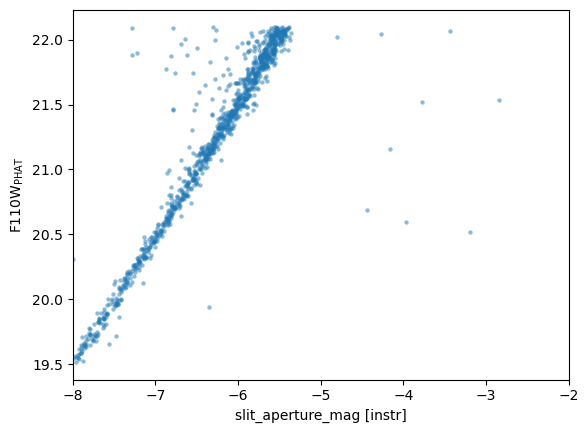

In [36]:
aps = photutils.SkyRectangularAperture(msata_inimg_candidates['coord_corr'], 
                                       .46*u.arcsec, .2*u.arcsec)
phot = photutils.aperture_photometry(i2d_img.data, aps, wcs=w)
phot['aperture_mag'] = -2.5*np.log10(phot['aperture_sum'])

plt.scatter(phot['aperture_mag'],
            msata_inimg_candidates['f110w_vega'],
            alpha=.5, lw=0, s=10)

plt.xlabel('slit_aperture_mag [instr]')
plt.ylabel(r'$\rm F110W_{PHAT}$')
plt.xlim(-8, -2)

plt.savefig('msata_phat_to_aper.png')

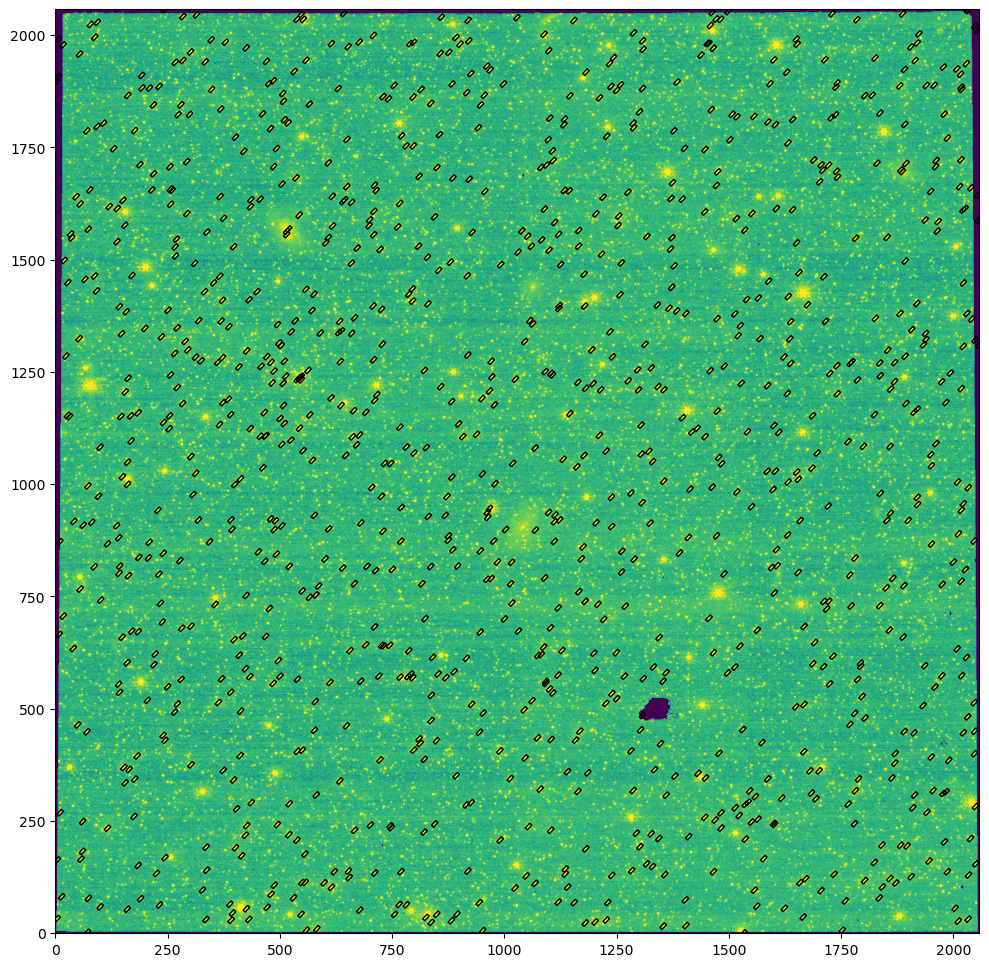

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())

aps.to_pixel(w).plot();

Try using David's catalog directly see if it's a simple offset

In [38]:
lvl2cat = Table.read('m31_nircam_calib.fits.gz')
lvl2cat['coord'] = SkyCoord.guess_from_table(lvl2cat, unit=u.deg)
lvl2cat

<Table length=282792>
  id         asemi               bsemi        ...       f475w                        coord                
                                              ...                                   deg,deg               
int64       float64             float64       ...      float64                      SkyCoord              
------ ------------------ ------------------- ... ------------------ -------------------------------------
     1 0.9390005469322205 0.48503097891807556 ... 27.422000885009766  11.512074723657722,42.10725396555577
     2 0.8969200849533081  0.6195357441902161 ... 26.051000595092773   11.505743655780327,42.1117451253592
     3 1.1276617050170898  0.7151619791984558 ... 26.323999404907227   11.5095136120729,42.109074446903776
     4 1.1406514644622803  0.7575315833091736 ... 26.386999130249023   11.510138831342308,42.1086231322583
     5 1.1733042001724243  0.9498933553695679 ... 26.128999710083008   11.5085661253876,42.109732964439935
     6 1.3220638036727905  0.9708824753761292 ...  26.08300018310547  11.514029744834403,42.10585925803062
     7 0.8286025524139404  0.6730826497077942 ... 28.114999771118164  11.517671335990807,42.10326448007288
     8 0.9736731648445129  0.6927480101585388 ...              99.99  11.518444976208892,42.10272760216794
     9 0.7975103855133057  0.6872077584266663 ... 27.190000534057617  11.518721873908948,42.10251954088532
   ...                ...                 ... ...                ...                                   ...
282784  6.239251613616943   2.735949993133545 ...              99.99  11.564505822426849,42.07743831466679
282785 1.3580039739608765  0.7273610830307007 ...              99.99  11.564961835205537,42.07698376454823
282786 10.428632736206055    7.30295467376709 ... 28.160999298095703  11.570831735975618,42.07300164785043
282787 2.8978326320648193  1.5476373434066772 ...              99.99   11.571526287688293,42.0721881404077
282788 7.8830485343933105  3.3739051818847656 ...   99.9990005493164 11.552422920647103,42.086259444449375
282789  2.770216703414917   1.145950436592102 ... 26.163000106811523   11.57311146182272,42.07111882775711
282790 1.2153801918029785  0.7319236993789673 ...  30.02400016784668   11.54831967222077,42.08891765615598
282791 1.0086278915405273  0.6461585164070129 ...              99.99 11.544836785464925,42.091386426679485
282792 11.740374565124512    8.31153678894043 ...              99.99  11.545634732596243,42.09121657311561

In [39]:
lvl2x, lvl2y = w.world_to_pixel(lvl2cat['coord'])

In [40]:
lvl2inimg = ((0 < lvl2x) & (lvl2x < i2d_img.shape[1]) & 
             (0 < lvl2y) & (lvl2y < i2d_img.shape[0]))
lvl2cat_inimg = lvl2cat[lvl2inimg]

(30.71437727927014, 60.71437727927014)

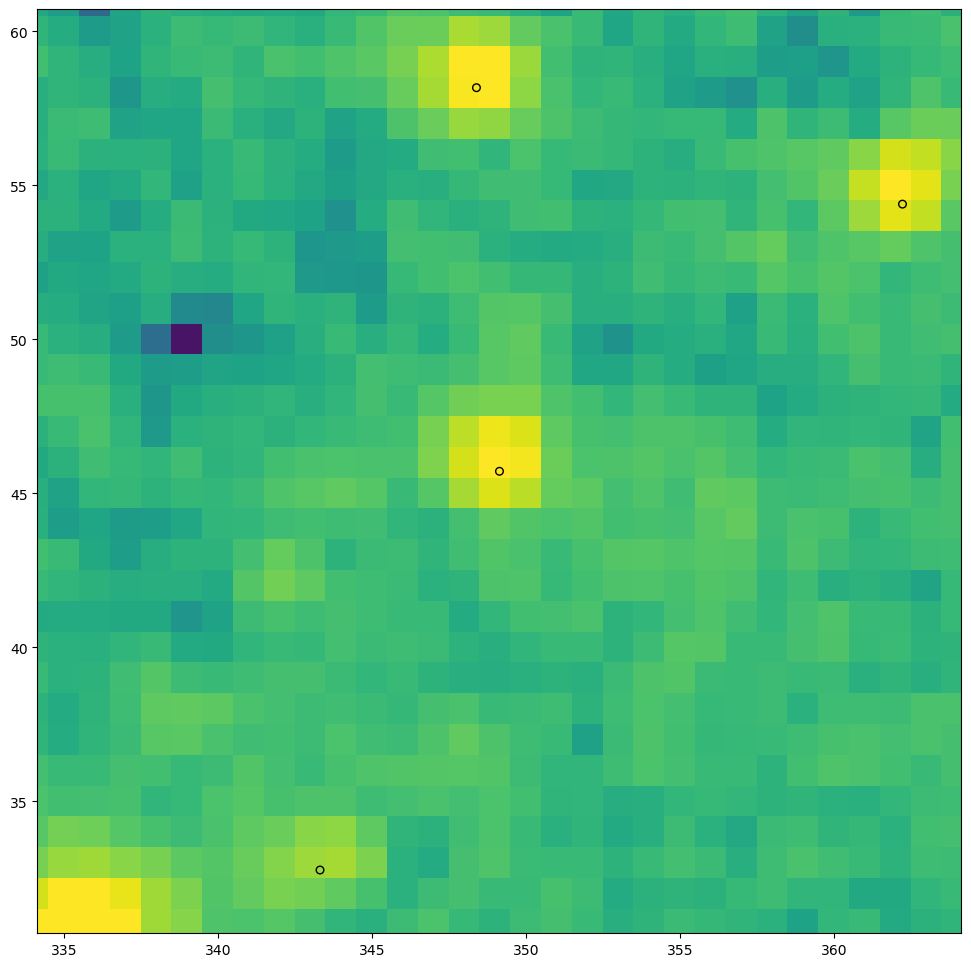

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_aspect('equal')

aviz.imshow_norm(i2d_img.data, ax=ax, origin='lower',
                interval=aviz.AsymmetricPercentileInterval(1, 99),
                stretch=aviz.LogStretch())


ax.scatter(lvl2x[lvl2inimg], lvl2y[lvl2inimg], s=30, linewidths=1, c='none', edgecolors='black')

i = np.random.randint(np.sum(inimg))

x0 = lvl2x[lvl2inimg][i]
y0 = lvl2y[lvl2inimg][i]
wi = 30

ax.set_xlim(x0 - wi/2, x0 + wi/2)
ax.set_ylim(y0 - wi/2, y0 + wi/2)

Try cross-matching David's catalog to phat directly to see the nature of the offset

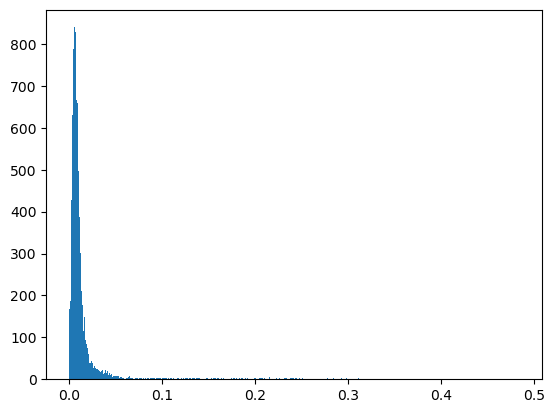

In [42]:
idx, d2d, _ = lvl2cat_inimg['coord'].match_to_catalog_sky(phat_tab['coord_corr'])

plt.hist(d2d.arcsec, bins='auto');

(5.9020295275047365, 3.4450248733719486)

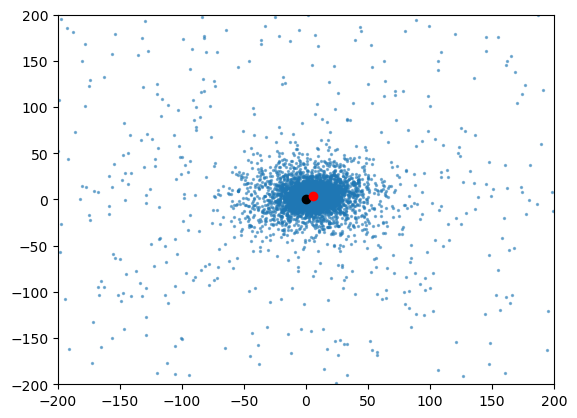

In [43]:
dra = lvl2cat_inimg['coord'].ra - phat_tab['coord_corr'][idx].ra
ddec = lvl2cat_inimg['coord'].dec - phat_tab['coord_corr'][idx].dec

plt.scatter(dra.marcsec, ddec.marcsec, s=2, alpha=.5)
plt.scatter([0], [0],c='k')
plt.scatter([np.median(dra.marcsec)], [np.median(ddec.marcsec)], c='r')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

np.median(dra.marcsec), np.median(ddec.marcsec)

Ok they match up very close.  Try removing the residual just to get a bit closer.

(0.023604011545330646,
 0.01889445400138356,
 39.60334140625774,
 30.313309322738224)

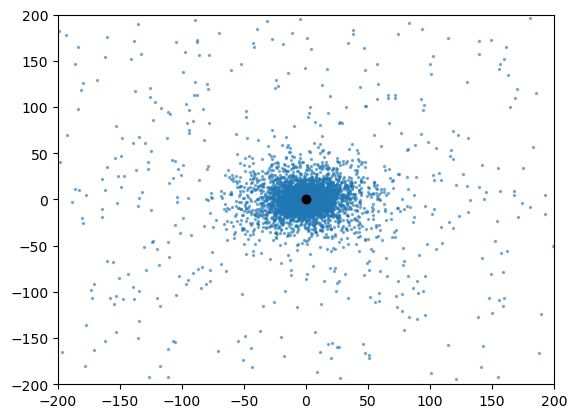

In [44]:
scoff = SkyCoord(ra=lvl2cat_inimg['coord'].ra - np.median(dra), dec=lvl2cat_inimg['coord'].dec - np.median(ddec))

idx, d2d, _ = scoff.match_to_catalog_sky(phat_tab['coord_corr'])

dra2 = scoff.ra - phat_tab['coord_corr'][idx].ra
ddec2 = scoff.dec - phat_tab['coord_corr'][idx].dec

plt.scatter(dra2.marcsec, ddec2.marcsec, s=2, alpha=.5)
plt.scatter([np.median(dra2.marcsec)], [np.median(ddec2.marcsec)], c='r')
plt.scatter([0], [0],c='k')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

np.median(dra2.marcsec), np.median(ddec2.marcsec), np.std(dra2.marcsec), np.std(ddec2.marcsec)

In [45]:
aps = photutils.SkyRectangularAperture(scoff, 
                                       .46*u.arcsec, .2*u.arcsec)
phot = photutils.aperture_photometry(i2d_img.data, aps, wcs=w)
phot['aperture_mag'] = -2.5*np.log10(phot['aperture_sum'])

2022-10-28 17:50:38,927 - stpipe - WARNING - /tmp/ipykernel_13979/2975058045.py:4: RuntimeWarning: divide by zero encountered in log10
  phot['aperture_mag'] = -2.5*np.log10(phot['aperture_sum'])



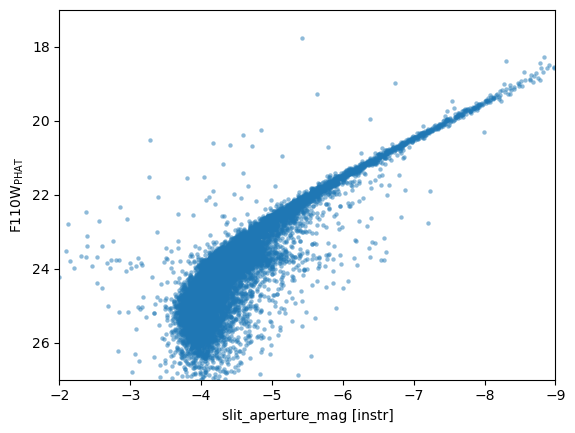

In [49]:
plt.scatter(phot['aperture_mag'],
            phat_tab['f110w_vega'][idx],
            alpha=.5, lw=0, s=10)

plt.xlabel('slit_aperture_mag [instr]')
plt.ylabel(r'$\rm F110W_{PHAT}$')
plt.xlim(-2, -9)
plt.ylim(27, 17)

plt.savefig('slit_ap_vs_phat.png')